In [1]:
import math
import random
from tqdm.notebook import trange

import numpy as np
print(np.__version__)

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

1.24.4
2.1.1


In [2]:
class ConnectFour:
    ''' Game definition for ConnectFour '''
    
    def __init__(self):
        self.row_count = 6
        self.col_count = 7
        self.action_size = self.col_count
        self.win_condition = 4

    def __repr__(self):
        return 'ConnectFour'

    def get_initial_state(self):
        ''' Get board with all zeros '''
        return np.zeros((self.row_count, self.col_count))

    def get_next_state(self, state, action, player):
        ''' Get the next state given the given action by the given player '''
        row = np.max(np.where(state[:, action] == 0))
        state[row, action] = player
        return state

    def get_valid_moves(self, state):
        ''' Get all the legal moves in the position '''
        return (state[0] == 0).astype(np.uint8)

    def check_win(self, state, action):
        ''' Check if the given action has led to a win '''
        if action == None:
            return False
        
        row = np.min(np.where(state[:, action] != 0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.win_condition):
                r = row + offset_row * i
                c = action + offset_column * i
                if (
                    r < 0 
                    or r >= self.row_count
                    or c < 0 
                    or c >= self.col_count
                    or state[r][c] != player
                ):
                    return i - 1
            return self.win_condition - 1

        return (
            count(1, 0) >= self.win_condition - 1 # vertical
            or (count(0, 1) + count(0, -1)) >= self.win_condition - 1 # horizontal
            or (count(1, 1) + count(-1, -1)) >= self.win_condition - 1 # top left diagonal
            or (count(1, -1) + count(-1, 1)) >= self.win_condition - 1 # top right diagonal
        )

    def get_value_and_terminated(self, state, action):
        ''' Get the value (win/tie) and if the game has terminated '''
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False

    def get_opponent(self, player):
        ''' Get the opponent of the player '''
        return -player

    def get_opponent_value(self, value):
        ''' Get the value from the opponent's perspective '''
        return -value

    def change_perspective(self, state, player):
        ''' Transform the state to be from the opponent's perspective '''
        return state * player

    def get_encoded_state(self, state):
        ''' Get the network-ready encoded state of the game '''
        encoded_state = np.stack((state == -1, state == 0, state == 1)).astype(np.float32)

        # check for batched states
        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0, 1)
        
        return encoded_state

In [3]:
class ResNet(nn.Module):
    ''' The residual neural network implementation for AlphaZero '''
    
    def __init__(self, game, num_resblocks, num_hidden, device):
        super().__init__()

        # store the specified device for computation
        self.device = device

        # initial NN block
        self.start_block = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        # shared portion of network between policy and value heads
        self.backbone = nn.ModuleList(
            [ResBlock(num_hidden) for _ in range(num_resblocks)]
        )

        # the portion of the network responsible for outputting policies
        self.policy_head = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.col_count, game.action_size)
        )

        # the portion of the network responsible for outputting values
        self.value_head = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.col_count, 1),
            nn.Tanh()
        )

        # send computation to the device
        self.to(device)

    def forward(self, x):
        ''' Feed forward implementation for this network '''
        x = self.start_block(x)
        for resblock in self.backbone:
            x = resblock(x)
        policy = self.policy_head(x)
        value = self.value_head(x)

        return policy, value

class ResBlock(nn.Module):
    ''' ResNet block '''
    
    def __init__(self, num_hidden):
        ''' Initialize the block '''
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        ''' Feed forward implementation for this block '''
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0. -1.  0. -1.  0.  1.]]
[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 1. 0. 0.]]

 [[1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 0.]
  [1. 1. 0. 1. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]]]
-0.0350162647664547


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


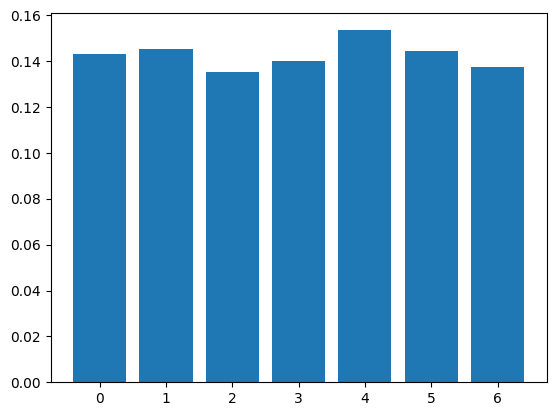

In [4]:
import matplotlib.pyplot as plt

game = ConnectFour()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

state = game.get_initial_state()
state = game.get_next_state(state, 2, -1)
state = game.get_next_state(state, 4, -1)
state = game.get_next_state(state, 6, 1)
state = game.get_next_state(state, 6, 1)

print(state)

encoded_state = game.get_encoded_state(state)

print(encoded_state)

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(game, 9, 128, device=device)
model.load_state_dict(torch.load(f'../models/{game}/model_7.pt', map_location=device), strict=False)
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

plt.bar(range(game.action_size), policy)
plt.show()

In [6]:
class Node:
    ''' A Monte Carlo Tree Search node '''
    
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

    def is_expanded(self):
        ''' Check if the node already has children. Since we expand all children of a node at once, we check for >0 children '''
        return len(self.children) > 0

    def select(self):
        ''' Select a child to explore '''
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        ''' Get how promising a move is from the opponent's perspective, normalized on [0,1] '''
        if child.visit_count == 0:
            q = 0
        else:
            q = 1 - ((child.value_sum / child.visit_count) + 1) / 2 

        return q + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        ''' Expand a node by adding all legal child moves '''
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)
        
                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

    def backpropagate(self, value):
        ''' Propagate value sums and visit counts from children to all parents '''
        self.value_sum += value
        self.visit_count += 1

        # flip value for opponent (parent)
        value = self.game.get_opponent_value(value)

        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    ''' A Monte Carlo Tree Search '''
    
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, state):
        ''' Expand and explore the MCTS and update value sums and visit counts '''
        # DEFINE ROOT
        root = Node(self.game, self.args, state, visit_count=1)

        # add some random noise to policy to increase exploration
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = ((1 - self.args['dirichlet_epsilon']) * 
                    policy + 
                    self.args['dirichlet_epsilon'] * 
                    np.random.dirichlet([self.args['dirichlet_alpha']] * 
                    self.game.action_size
                ))
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            # SELECTION
            while node.is_expanded():
                node = node.select()
                
            # check for end of game
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)

            # flip parent value
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                # get output from model
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )

                # change policy to proabability distribution
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()

                # mask out illegal moves
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves

                # readjust back to probability distribution
                policy /= np.sum(policy)

                # get the value as a number from singleton tensor
                value = value.item()
                
                # EXPANSION
                node.expand(policy)
    
            # BACKPROP
            node.backpropagate(value)

        # probabilities of action being good
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count

        action_probs /= np.sum(action_probs)
        return action_probs

In [7]:
class AlphaZero:
    ''' AlphaZero class for self-play and training '''
    
    def __init__(self, model, optimizer, game, args):
        ''' Initialize the AlphaZero instance '''
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)

    def self_play(self):
        ''' Run a single self-play game until completion and generate outcome-appended training data '''
        
        memory = []
        player = 1
        state = self.game.get_initial_state()

        while True:
            # get the current state and action probabilities from MCTS
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)

            # record a game snapshot
            memory.append((neutral_state, action_probs, player))

            # randomly sample an action from the distribution
            adjusted_action_probs = action_probs ** (1 / self.args['temperature']) # add flexibility for exploration / exploitation
            adjusted_action_probs /= np.sum(adjusted_action_probs)
            action = np.random.choice(self.game.action_size, p=adjusted_action_probs)

            # get the next state given the chosen action
            state = self.game.get_next_state(state, action, player)

            # check for game completion
            value, is_terminal = self.game.get_value_and_terminated(state, action)

            if is_terminal:
                # get all states and policies from the game and append the outcome
                return [(
                    self.game.get_encoded_state(h_state),
                    h_action_probs,
                    value if h_player == player else self.game.get_opponent_value(value)
                ) for h_state, h_action_probs, h_player in memory]

            # swap the player and loop
            player = self.game.get_opponent(player)

    def train(self, memory):
        ''' Train the model '''

        # randomize training data
        random.shuffle(memory)
        
        for batch_i in range(0, len(memory), self.args['batch_size']):
            # sample a batch from training data
            sample = memory[batch_i : min(len(memory) - 1, batch_i + self.args['batch_size'])]

            # transpose list of tuples to independent lists
            state, policy_targets, value_targets = zip(*sample)

            # convert to numpy arrays
            state = np.array(state)
            policy_targets = np.array(policy_targets)
            value_targets = np.array(value_targets).reshape(-1, 1) # wrap each value in its own array for simplicity later

            # convert to tensors
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            # get model outputs
            out_policy, out_value = self.model(state)

            # get loss
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            # minimize loss via backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def learn(self):
        ''' Generate self-play training data and train the model on it '''
        
        for iter in range(self.args['num_iters']):
            memory = []
            
            self.model.eval()
            for self_play_iter in trange(self.args['num_self_play_iters']):
                memory += self.self_play()

            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            torch.save(self.model.state_dict(), f'../models/{self.game}/model_{iter}.pt')
            torch.save(self.optimizer.state_dict(), f'../models/{self.game}/optimizer_{iter}.pt')

In [8]:
class MCTSParallel:
    ''' A parallelized Monte Carlo Tree Search '''
    
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, states, sp_games):
        ''' Expand and explore the MCTS and update value sums and visit counts '''

        # add some random noise to policy to increase exploration
        policy, _ = self.model(torch.tensor(self.game.get_encoded_state(states), device=self.model.device))
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = ((1 - self.args['dirichlet_epsilon']) * 
                    policy + 
                    self.args['dirichlet_epsilon'] * 
                    np.random.dirichlet([self.args['dirichlet_alpha']] * 
                    self.game.action_size,
                    size=policy.shape[0]
                ))

        for i, spg in enumerate(sp_games):
            # get policy for this self-play game
            spg_policy = policy[i]

            # mask illegal moves out of policy
            valid_moves = self.game.get_valid_moves(states[i])
            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)
    
            spg.root = Node(self.game, self.args, states[i], visit_count=1)
            
            spg.root.expand(spg_policy)
        
        for search in range(self.args['num_searches']):
            for spg in sp_games:
                spg.node = None
                node = spg.root
                
                # SELECTION
                while node.is_expanded():
                    node = node.select()
                    
                # check for end of game
                value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
    
                # flip parent value
                value = self.game.get_opponent_value(value)

                # backpropagate value sums and visit counts if game ended
                if is_terminal:
                    node.backpropagate(value)

                # otherwise, store the current node
                else:
                    spg.node = node

            expandable_sp_games = [map_i for map_i in range(len(sp_games)) if sp_games[map_i].node is not None]

            if len(expandable_sp_games) > 0:
                states = np.stack([sp_games[map_i].node.state for map_i in expandable_sp_games])

                # get output from model
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
                )

                # change policy to proabability distribution
                policy = torch.softmax(policy, axis=1).cpu().numpy()

                # get value as numpy
                value = value.cpu().numpy()

            for i, map_i in enumerate(expandable_sp_games):
                # get the current node for the self-play game
                node = sp_games[map_i].node
                
                # get policy and value from self-play game
                spg_policy, spg_value = policy[i], value[i]
                
                 # mask out illegal moves
                valid_moves = self.game.get_valid_moves(node.state)
                spg_policy *= valid_moves

                # readjust back to probability distribution
                spg_policy /= np.sum(spg_policy)
                
                # expand the node
                node.expand(spg_policy)

                # backpropagate values and visit counts
                node.backpropagate(spg_value)

In [9]:
class AlphaZeroParallel:
    ''' Parallelized AlphaZero class for self-play and training '''
    
    def __init__(self, model, optimizer, game, args):
        ''' Initialize the AlphaZero instance '''
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTSParallel(game, args, model)

    def self_play(self):
        ''' Run a single self-play game until completion and generate outcome-appended training data '''
        
        return_memory = []
        player = 1
        sp_games = [SPG(self.game) for _ in range(self.args['num_parallel_games'])]

        while len(sp_games) > 0:
            # get states from all games
            states = np.stack([spg.state for spg in sp_games])
            
            # get neutral states from all games
            neutral_states = self.game.change_perspective(states, player)

            # MCTS call
            self.mcts.search(neutral_states, sp_games)

            # loop games in reverse to avoid issues when removing terminated games from list
            for i in range(len(sp_games))[::-1]:
                spg = sp_games[i]
                
                # probabilities of action being good
                action_probs = np.zeros(self.game.action_size)
                for child in spg.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)
    
                # record a game snapshot
                spg.memory.append((spg.root.state, action_probs, player))
    
                # randomly sample an action from the distribution
                adjusted_action_probs = action_probs ** (1 / self.args['temperature']) # add flexibility for exploration / exploitation
                adjusted_action_probs /= np.sum(adjusted_action_probs)
                action = np.random.choice(self.game.action_size, p=adjusted_action_probs)
    
                # get the next state given the chosen action
                spg.state = self.game.get_next_state(spg.state, action, player)
    
                # check for game completion
                value, is_terminal = self.game.get_value_and_terminated(spg.state, action)
    
                if is_terminal:
                    # get all states and policies from the games and append the outcomes
                    for h_neutral_state, h_action_probs, h_player in spg.memory:
                        h_outcome = value if h_player == player else self.game.get_opponent_value(value)
                        return_memory.append((
                            self.game.get_encoded_state(h_neutral_state),
                            h_action_probs,
                            h_outcome
                        ))
    
                    del sp_games[i]

            # swap the player and loop
            player = self.game.get_opponent(player)

        return return_memory

    def train(self, memory):
        ''' Train the model '''

        # randomize training data
        random.shuffle(memory)
        
        for batch_i in range(0, len(memory), self.args['batch_size']):
            # sample a batch from training data
            sample = memory[batch_i : min(len(memory) - 1, batch_i + self.args['batch_size'])]

            # transpose list of tuples to independent lists
            state, policy_targets, value_targets = zip(*sample)

            # convert to numpy arrays
            state = np.array(state)
            policy_targets = np.array(policy_targets)
            value_targets = np.array(value_targets).reshape(-1, 1) # wrap each value in its own array for simplicity later

            # convert to tensors
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            # get model outputs
            out_policy, out_value = self.model(state)

            # get loss
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            # minimize loss via backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def learn(self):
        ''' Generate self-play training data and train the model on it '''
        
        for iter in range(self.args['num_iters']):
            memory = []
            
            self.model.eval()
            for self_play_iter in trange(self.args['num_self_play_iters'] // self.args['num_parallel_games']):
                memory += self.self_play()

            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            torch.save(self.model.state_dict(), f'../models/{self.game}/model_{iter}.pt')
            torch.save(self.optimizer.state_dict(), f'../models/{self.game}/optimizer_{iter}.pt')

class SPG:
    ''' A self-play game '''
    def __init__(self, game):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None

In [12]:
game = ConnectFour()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(game, 9, 128, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 600,
    'num_iters': 8,
    'num_self_play_iters': 500,
    'num_parallel_games': 100,
    'num_epochs': 4,
    'batch_size': 128,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphazero = AlphaZeroParallel(model, optimizer, game, args)
alphazero.learn()

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'Node' is not defined

In [ ]:
game = ConnectFour()
player = 1

args = {
    'C': 2,
    'num_searches': 600,
    'dirichlet_epsilon': 0.0,
    'dirichlet_alpha': 0.3
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(game, 9, 128, device)
model.load_state_dict(torch.load(f'../models/{game}/model_7.pt', map_location=device), strict=False)
model.eval()

mcts = MCTS(game, args, model)

state = game.get_initial_state()

while True:
    print(state)

    if player == 1:
        valid_moves = game.get_valid_moves(state)
        print('Valid Moves:' , [i for i in range(game.action_size) if valid_moves[i] == 1])
        action = int(input(f'{player}: '))
    
        if valid_moves[action] == 0:
            print('Invalid move')
            continue
    else:
        neutral_state = game.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        print(mcts_probs)
        action = np.argmax(mcts_probs)

    state = game.get_next_state(state, action, player)

    value, is_terminal = game.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, 'won')
        else:
            print('Draw')
        break

    player = game.get_opponent(player)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Valid Moves: [0, 1, 2, 3, 4, 5, 6]


1:  3


[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
[0.14833333 0.15       0.13333333 0.13833333 0.14666667 0.13166667
 0.15166667]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0. -1.]]
Valid Moves: [0, 1, 2, 3, 4, 5, 6]


1:  2


[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0. -1.]]
[0.165      0.18666667 0.12333333 0.13333333 0.13333333 0.12833333
 0.13      ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  1.  0.  0. -1.]]
Valid Moves: [0, 1, 2, 3, 4, 5, 6]


1:  4


[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  1.  1.  0. -1.]]
